# Import Libraries

In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.12.0'

In [3]:
import glob
import os
import time

import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
from IPython import display
from tensorflow.keras import layers

# Download MNIST Data

In [4]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


In [5]:
train_images.shape

(60000, 28, 28)

In [6]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype(
    "float32"
) # 1channel
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [7]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [8]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images)
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [9]:
tf.random.normal([1,100])

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[-1.4772449e-01, -7.0043367e-01, -3.9041311e-01, -1.7657405e+00,
        -1.8373992e-01, -7.4362242e-01, -9.0524590e-01,  8.7895870e-02,
         1.1638321e+00,  6.9161195e-01,  1.3148528e+00,  4.2038080e-01,
         9.8916787e-01, -9.2622405e-01, -8.0474722e-01,  1.7968521e+00,
        -4.9722239e-01,  1.5882329e+00, -5.6204087e-01, -8.5912329e-01,
         1.9979339e-02, -2.6706888e-03,  1.5386493e+00, -1.8520245e-01,
         3.4978029e-01,  2.2450359e+00,  5.3242296e-01, -5.3395021e-01,
        -2.1374788e+00, -4.6587789e-01, -9.2845058e-01,  1.5455165e+00,
         1.4943175e+00, -6.3179862e-01, -1.0799828e+00,  2.2478293e-01,
         1.2378155e+00, -1.9752486e-01, -3.9097783e-01, -7.1436220e-01,
         9.1358662e-01, -5.7297707e-01,  7.1522307e-01, -4.0346596e-01,
         7.9956567e-01,  1.6055045e+00, -6.4479673e-01, -1.0620518e+00,
        -1.8082364e+00,  7.0203453e-01,  1.9744288e+00, -1.4263098e+00,
         1.875

#Generator

In [10]:
def make_generator_model():
  model = tf.keras.Sequential()
  model.add(layers.Dense(7*7*256,use_bias=False,input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((7,7,256)))

  model.add(layers.Conv2DTranspose(128,(5,5),strides=(1,1),padding="same",use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64,(5,5),strides = (2,2), padding="same",use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(1,(5,5),strides=(2,2),padding="same",use_bias=False,activation="tanh"))

  assert model.output_shape == (None,28,28,1)

  return model

image shape: (1, 28, 28, 1)


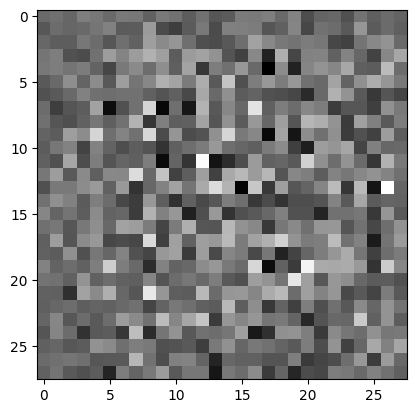

In [11]:
generator = make_generator_model()

noise = tf.random.normal([1,100])
generated_image = generator(noise,training=False)
print('image shape:',generated_image.shape)
plt.imshow(generated_image[0, :, : , 0],cmap='gray')

In [12]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

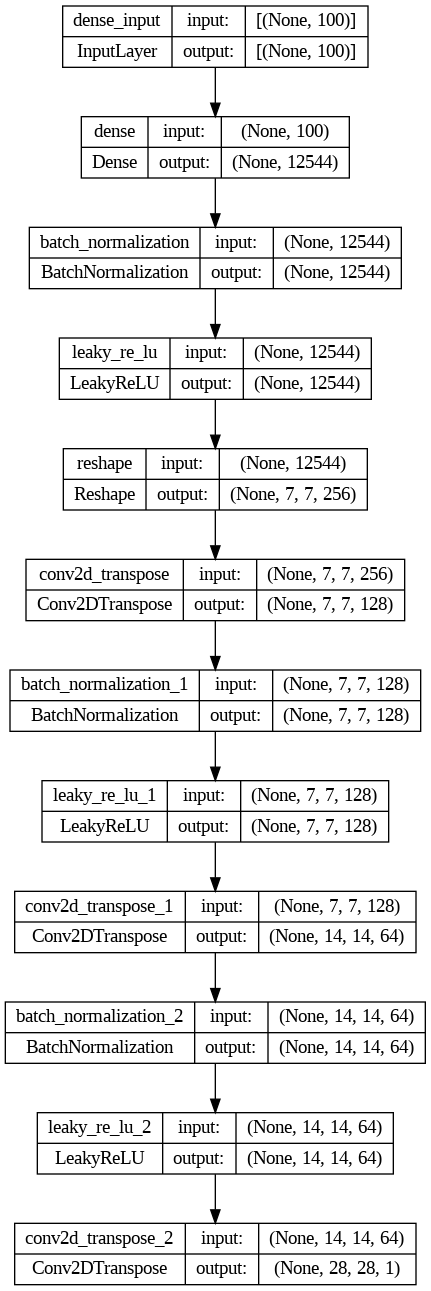

In [13]:
tf.keras.utils.plot_model(generator, show_shapes=True, show_layer_names=True)

# Discriminator

In [14]:
def make_discriminator_model():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64,(5,5),strides=(2,2),padding="same",input_shape=(28,28,1)))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128,(5,5),strides = (2,2),padding="same"))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1))
  assert model.output_shape == (None,1)

  return model

In [15]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-0.00224754]], shape=(1, 1), dtype=float32)


In [16]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

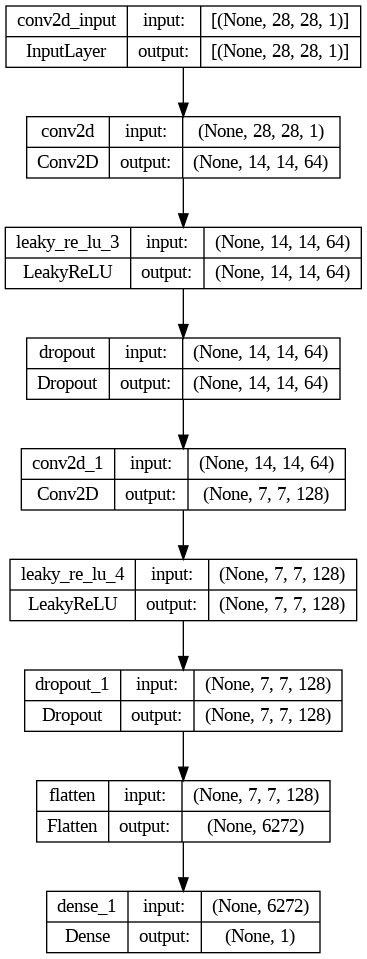

In [17]:
tf.keras.utils.plot_model(
    discriminator, show_shapes=True, show_layer_names=True
)

# Defining Loss

In [18]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [33]:
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output),real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

In [20]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output),fake_output)

In [21]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [22]:
#define checkpoints
checkpoint_dir = "./gan_training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir,"ckpt")
checkpoint = tf.train.Checkpoint(
    generator_optimizer = generator_optimizer,
    discriminator_optimizer = discriminator_optimizer,
    generator = generator,
    discriminator = discriminator
)

In [23]:
EPOCHS = 50
NOISE_DIM = 100
NUM_EXAMPLES_TO_GENERATE = 16
#random seed to generate MNIST data at each epoch
seed = tf.random.normal([NUM_EXAMPLES_TO_GENERATE, NOISE_DIM])

# Training

In [35]:
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE,NOISE_DIM])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_output = discriminator(images,training=True)
    fake_output = discriminator(generated_images,training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output,fake_output)

  #get gradients
  gradients_of_generator = gen_tape.gradient(gen_loss,generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  #optimizing
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))



In [31]:
def train(dataset,epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    display.clear_output(wait=True)
    #pass to generate fake data at each epoch from seed
    generate_and_save_images(generator,epoch+1,seed)

    if (epoch+1)%15 == 0:#save model at every 15 epochs
      checkpoint.save(file_prefix=checkpoint_prefix)

    print(f"Time for epoch{epoch+1} is {time.time()-start} secs")

  display.clear_output(wait=True)
  generate_and_save_images(generator,epochs,seed)

In [27]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input,training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow(predictions[i, :, :, 0]*127.5 + 127.5,cmap="gray")
    plt.axis("off")

  plt.savefig(f"./gan_images/images_at_epoch_{epoch:04d}.png")
  plt.show()

In [28]:
!test -d ./gan_images || mkdir ./gan_images/

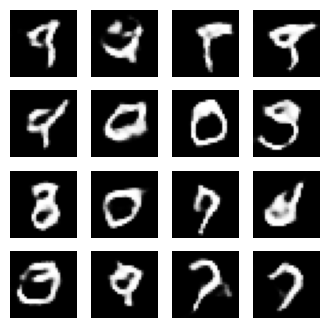

In [36]:
train(train_dataset, EPOCHS)

In [38]:
# !zip -r /content/gan_images.zip /content/gan_images

In [39]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

<ipython-input-40-8b5fa01e60e3>:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-40-8b5fa01e60e3>:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


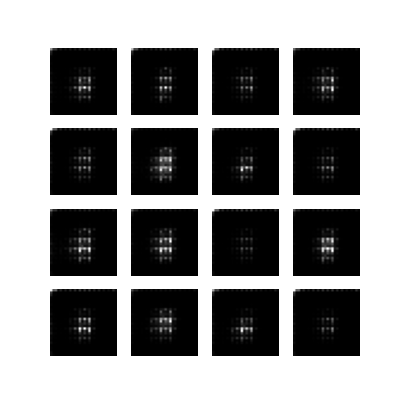

In [40]:
anim_file = "dcgan.gif"

with imageio.get_writer(anim_file, mode="I") as writer:
    filenames = glob.glob("./gan_images/image*.png")
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2 * (i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

display.Image(filename=anim_file)